In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

train = pd.read_csv("/Users/Sinyer/Desktop/kaggle/train.csv")
test = pd.read_csv("/Users/Sinyer/Desktop/kaggle/test.csv")
all_X = pd.concat((train.loc[:, 'MSSubClass':'SaleCondition'],test.loc[:, 'MSSubClass':'SaleCondition']))

numeric_feats = all_X.dtypes[all_X.dtypes != "object"].index
all_X[numeric_feats] = all_X[numeric_feats].apply(lambda x: (x - x.mean()) / (x.std()))
all_X = pd.get_dummies(all_X, dummy_na=True)
all_X = all_X.fillna(all_X.mean())

num_train = train.shape[0]

X_train = all_X[:num_train].as_matrix()
X_test = all_X[num_train:].as_matrix()
y_train = train.SalePrice.as_matrix()

from mxnet import ndarray as nd
from mxnet import autograd
from mxnet import gluon

X_train = nd.array(X_train)
y_train = nd.array(y_train)
y_train.reshape((num_train, 1))

X_test = nd.array(X_test)

In [2]:
square_loss = gluon.loss.L2Loss()

In [3]:
def get_rmse_log(net, X_train, y_train):
    num_train = X_train.shape[0]
    clipped_preds = nd.clip(net(X_train), 1, float('inf'))
    return np.sqrt(2 * nd.sum(square_loss(nd.log(clipped_preds), nd.log(y_train))).asscalar() / num_train)

def get_net():
    net = gluon.nn.Sequential()
    with net.name_scope():
        net.add(gluon.nn.Dense(1024,activation='relu'))
        net.add(gluon.nn.Dropout(0.5))
        net.add(gluon.nn.Dense(1))
    net.initialize()
    return net

In [4]:
def train(net, X_train, y_train, X_test, y_test, epochs, verbose_epoch, learning_rate, weight_decay):
    train_loss = []
    if X_test is not None:
        test_loss = []
    batch_size = 100
    dataset_train = gluon.data.ArrayDataset(X_train, y_train)
    data_iter_train = gluon.data.DataLoader(
        dataset_train, batch_size,shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': learning_rate, 'wd': weight_decay})
    net.collect_params().initialize(force_reinit=True)
    for epoch in range(epochs):
        for data, label in data_iter_train:
            with autograd.record():
                output = net(data)
                loss = square_loss(output, label)
            loss.backward()
            trainer.step(batch_size)
            cur_train_loss = get_rmse_log(net, X_train, y_train)
        if epoch > verbose_epoch:
            print("Epoch %d, train loss: %f" % (epoch, cur_train_loss))
        train_loss.append(cur_train_loss)
        if X_test is not None:    
            cur_test_loss = get_rmse_log(net, X_test, y_test)
            test_loss.append(cur_test_loss)
    plt.plot(train_loss)
    plt.legend(['train'])
    if X_test is not None:
        plt.plot(test_loss)
        plt.legend(['train','test'])
    plt.show()
    if X_test is not None:
        return cur_train_loss, cur_test_loss
    else:
        return cur_train_loss

In [5]:
def k_fold_cross_valid(k, epochs, verbose_epoch, X_train, y_train, learning_rate, weight_decay):
    assert k > 1
    fold_size = X_train.shape[0] // k
    train_loss_sum = 0.0
    test_loss_sum = 0.0
    for test_i in range(k):
        X_val_test = X_train[test_i * fold_size: (test_i + 1) * fold_size, :]
        y_val_test = y_train[test_i * fold_size: (test_i + 1) * fold_size]

        val_train_defined = False
        for i in range(k):
            if i != test_i:
                X_cur_fold = X_train[i * fold_size: (i + 1) * fold_size, :]
                y_cur_fold = y_train[i * fold_size: (i + 1) * fold_size]
                if not val_train_defined:
                    X_val_train = X_cur_fold
                    y_val_train = y_cur_fold
                    val_train_defined = True
                else:
                    X_val_train = nd.concat(X_val_train, X_cur_fold, dim=0)
                    y_val_train = nd.concat(y_val_train, y_cur_fold, dim=0)
        net = get_net()
        train_loss, test_loss = train(
            net, X_val_train, y_val_train, X_val_test, y_val_test, 
            epochs, verbose_epoch, learning_rate, weight_decay)
        train_loss_sum += train_loss
        print("Test loss: %f" % test_loss)
        test_loss_sum += test_loss
    return train_loss_sum / k, test_loss_sum / k

Epoch 47, train loss: 0.107904
Epoch 48, train loss: 0.106057
Epoch 49, train loss: 0.107166


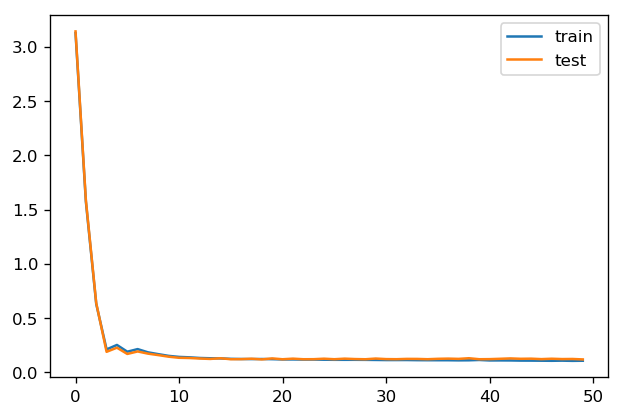

Test loss: 0.119364
Epoch 47, train loss: 0.102425
Epoch 48, train loss: 0.103100
Epoch 49, train loss: 0.103665


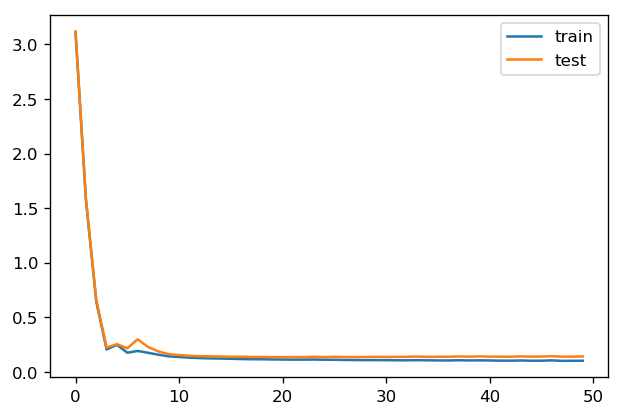

Test loss: 0.143018
Epoch 47, train loss: 0.103278
Epoch 48, train loss: 0.103177
Epoch 49, train loss: 0.102361


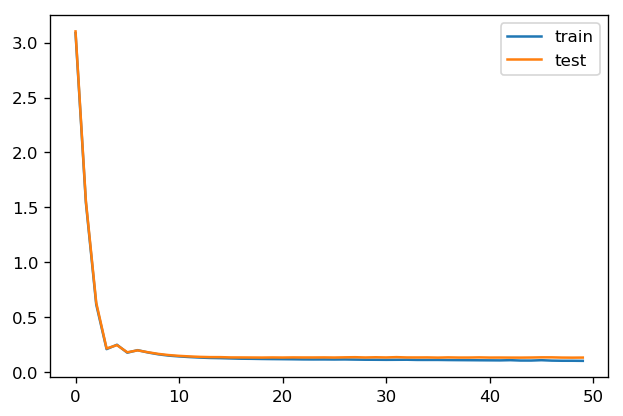

Test loss: 0.132287
Epoch 47, train loss: 0.106505
Epoch 48, train loss: 0.106032
Epoch 49, train loss: 0.106567


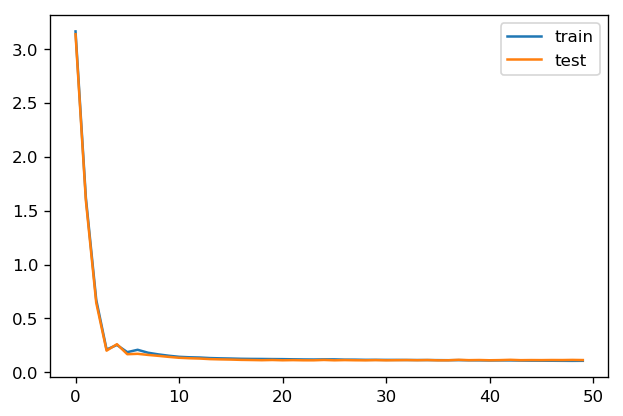

Test loss: 0.113457
Epoch 47, train loss: 0.100858
Epoch 48, train loss: 0.102223
Epoch 49, train loss: 0.103761


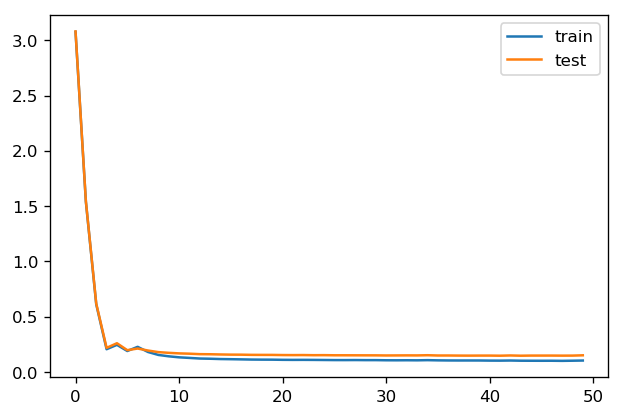

Test loss: 0.151026
5-fold validation: Avg train loss: 0.104704, Avg test loss: 0.131830


In [6]:
k = 5
epochs = 50
verbose_epoch = 49
learning_rate = 0.05
weight_decay = 170

# train_loss, test_loss = k_fold_cross_valid(k, epochs, verbose_epoch, X_train, y_train, learning_rate, weight_decay)
# print("%d-fold validation: Avg train loss: %f, Avg test loss: %f" % (k, train_loss, test_loss))

Epoch 47, train loss: 0.104336
Epoch 48, train loss: 0.103704
Epoch 49, train loss: 0.103786


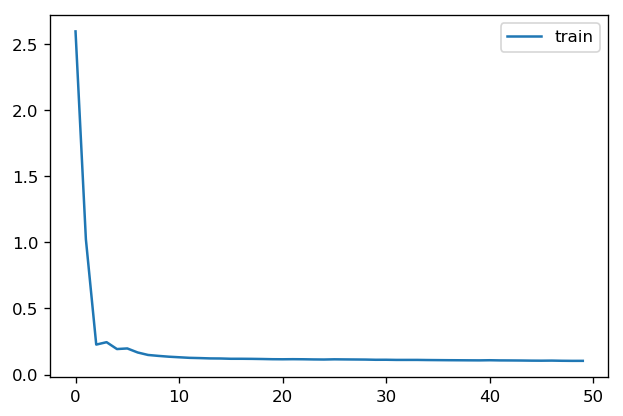

In [7]:
def learn(epochs, verbose_epoch, X_train, y_train, test, learning_rate,
          weight_decay):
    net = get_net()
    train(net, X_train, y_train, None, None, epochs, verbose_epoch, 
          learning_rate, weight_decay)
    preds = net(X_test).asnumpy()
    test['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test['Id'], test['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)
    
learn(epochs, verbose_epoch, X_train, y_train, test, learning_rate, weight_decay)